# Notebook to show workflow

### plots stuff

In [1]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

plt.rcParams['figure.figsize'] = [15, 5]
EPS = 0.000001

### some tricks

In [2]:
import sys
import os

search_tools_path = os.path.join(os.getcwd(), 'search_tools')
if search_tools_path not in sys.path:
    sys.path.append(search_tools_path)

In [3]:
%load_ext autoreload
%autoreload 2

### any workflow needs these imports

In [4]:
from moving_ai.mai_map_reader import MaiReader, MaiMaps
from pipeline import *
from run_result import RunResult

# Let's test A*

In [5]:
from algorithms.astar import Astar
from algorithms.astar_heuristics import diagonal_dist

### Let's define processor which checks that A* is correct

Processors expects a_result of type `List[Tuple[str, List[RunResult]]]`

(i.e. each element of list is $ (\mathrm{algorithm\_name}, [res_1, res_2, res_3,..]) $)

In [6]:
def process(a_results):
    for a_name, rs in a_results:
        for r in rs:
            if abs(r.act_len - r.opt_len) > EPS:
                print(f'Wrong result for algorithm: {a_name}')
                print(f'task: {r.task}, expected: {r.opt_len}, actual: {r.act_len}')
                return
    print('Everything is ok!')

### Let's build simple pipeline

In [7]:
p1 = Pipeline(
    reader=MaiReader(MaiMaps.ARENA),
    algorithms=[Astar(diagonal_dist)],
    processor=LProcessor(process)
)
p1.run()

Everything is ok!


### Let's compare manhattan and diagonal

In [8]:
from algorithms.astar_heuristics import diagonal_dist, manhattan_dist

from processors.plot_expanded_and_actual_length_ratio import PlotExpandedAndActualLengthRatio
from processors.print_suboptimals import PrintSuboptimals

In [9]:
p2 = Pipeline(
    reader = p1.reader,
    algorithms = [Astar(diagonal_dist), Astar(manhattan_dist)],
    processor = PlotExpandedAndActualLengthRatio().then(PrintSuboptimals())
)

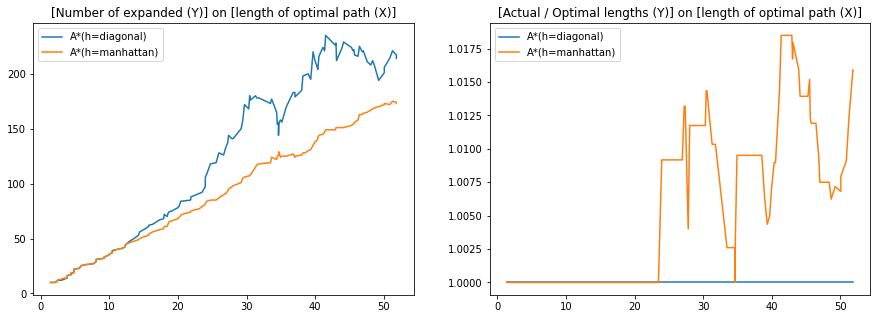

Suboptimals:
-----------  ---------------
             A*(h=manhattan)
count        20
count %      15.4 %
worst ratio  1.09
mean subopt  1.04
-----------  ---------------


In [10]:
p2.run()

### Let's find task which is the worst for manhattan

In [11]:
def find_worst_task(a_results):
    worst_res = max(a_results[-1][1], key=lambda r:r.act_div_opt())
    return worst_res.task

t = p2.with_processor(find_worst_task).run()
t

Task(start_c=(24, 25), goal_c=(13, 4), opt_len=25.55634918)

### Let's visualize map

In [12]:
from moving_ai.mai_map_visualizer import VisualizeMaiMap

p3 = Pipeline(
    reader=MaiReader(MaiMaps.ARENA).with_task(t),
    algorithms=[Astar(diagonal_dist), Astar(manhattan_dist)],
    processor=VisualizeMaiMap()
)

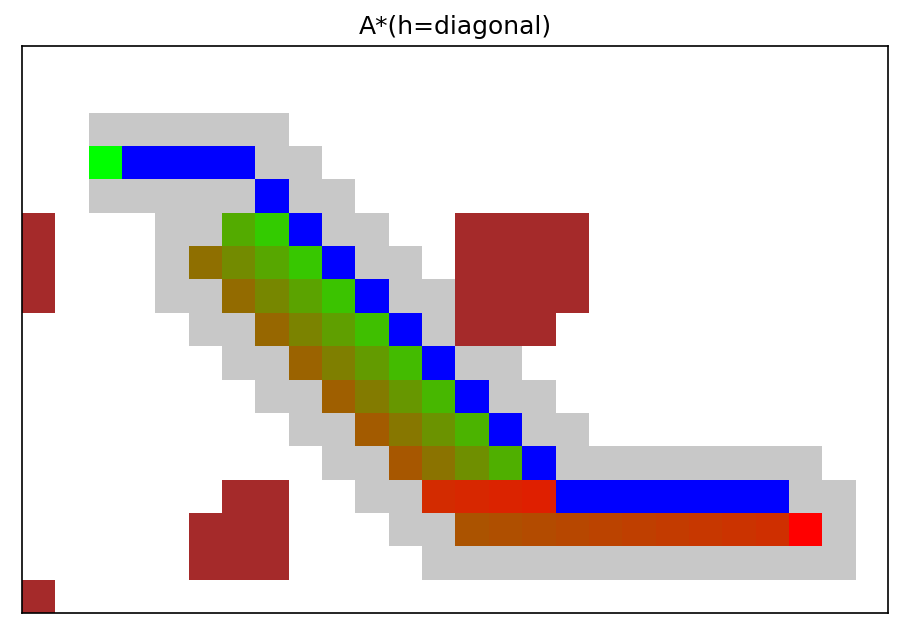

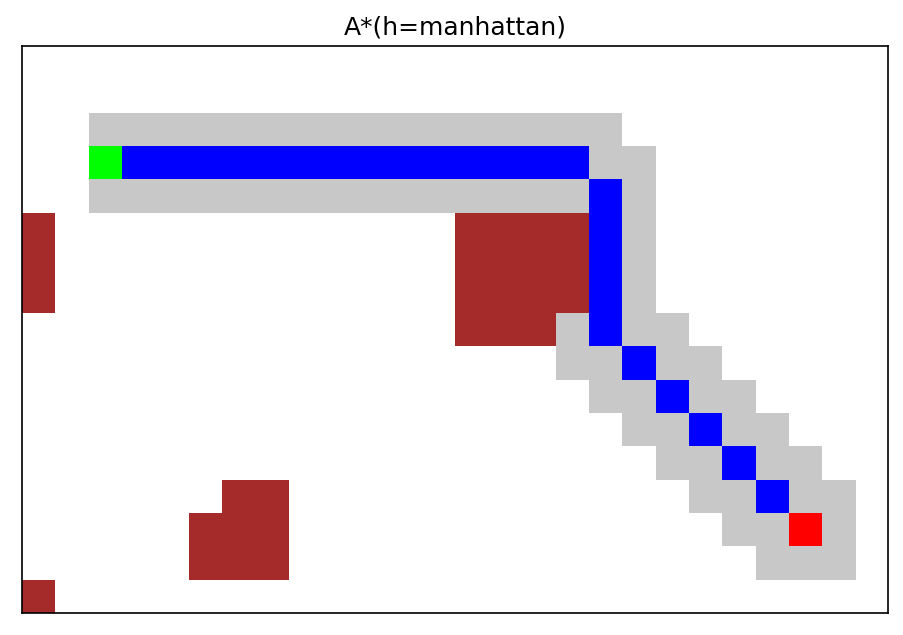

In [13]:
p3.run()